#  Alba Rodríguez Berenguel
# MCD - CUNEF
# Técnicas de Predicción: series temporales

En este trabajo voy a tratar con un fichero que contiene los datos de diez tiendas de la cadena de supermercados TOSCOS. Estos datos son diarios y van desde el 1 de enero de 2013 hasta el 31 de julio de 2015. El objetivo será predecir las ventas totales diarias y semanales, desde el 1 de agosto hasta el 10 de septiembre de 2015.

Para llevar a cabo el proyecto voy a realizar distintos notebooks. En este primer notebook, me voy a centrar principalmente en preparar los datos, de cara al diseño de los modelos de predicción. Y por otra parte, hacer algunas visualizaciones para comprender mejor el comportamiento.

Los pasos que voy a seguir son los siguientes:

1. Lectura de los datos
2. Tratamiento de los valores 0

In [1]:
#Librerias empleadas en la práctica
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import statistics
import warnings
warnings.filterwarnings('ignore')

## 1. Lectura de los datos

En primer lugar llevaré a cabo la lectura del fichero que contiene los datos con los que voy a trabajar *(datos.csv)* y algunas modificaciones simples como establecer el índice o su ordenación.

In [18]:
# Leo los datos, asignado que la columna fechas sea tipo datetime
df_datos = (pd.read_csv('datos.csv')
            .assign(**{'Date': lambda df: pd.to_datetime(df['Date'])}))

#Para visualizar mejor los datos, ordeno el data frame por tienda y fecha
df_datos = df_datos.sort_values(by=['Store', 'Date'])

#Establezco la columna de fechas como indice
df_datos = df_datos.set_index('Date')

df_datos.head()

Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
Date                                                                      
2013-01-01   T1a          2      0          0     0      0            a   
2013-01-02   T1a          3   6072        697     1      0            0   
2013-01-03   T1a          4   5429        609     1      0            0   
2013-01-04   T1a          5   6553        709     1      0            0   
2013-01-05   T1a          6   6382        764     1      0            0   

            SchoolHoliday  
Date                       
2013-01-01              1  
2013-01-02              1  
2013-01-03              1  
2013-01-04              1  
2013-01-05              0

Las variables que tengo en el dataframe son las siguientes:

- Date: Fecha diaria.
- Store: Tienda (T1a, T1b, T1c, T2a, T2b, T2c, T3a, T3b, T3c, T3d).
- DayOfWeek: Día de la semana.
- Sales: Ventas diaria.
- Customers: Clientes diarios.
- Open: Variable categórica que indica 1 si la tienda está abierta y 0 si está cerrada.
- Promo: Variable categórica que indica 1 si hay promoción y 0 si no.
- StateHoliday: Indica 0 si es festivo
- SchoolHoliday: Indica 0 si no es lectivo y 1 si lo es.

No obstante, las variables que realmente me interesan y voy a utilizar en los modelos son *Date* y *Sales*; *Store* también es importante, pero como más adelante agruparé los datos, ya que las predicciones las haré del total no tiene tanta relevancia. Algunas de las variables no mencionadas las analizaré más adelante aunque no son necesarias para los modelos.

In [5]:
#Elimino del df las columnas que no voy a emplear
sales_df = df_datos[['Store', 'Sales']]

sales_df.head()

Store  Sales
Date                   
2013-01-01   T1a      0
2013-01-02   T1a   6072
2013-01-03   T1a   5429
2013-01-04   T1a   6553
2013-01-05   T1a   6382

## 2. Tratamiento de los valores 0

En la columna de ventas hay algunos valores que son 0, no son missing, sino que corresponden a días que las tiendas han estado cerradas. He decidido tratar estos valores y sustituirlos, puesto que de lo contrario influirían en los modelos, haciendo creer que las ventas son inferiores y produciendo un error mayor.

Para sustituirlos voy a analizar cada caso y decidiré los valores más adecuados que se asemejen a días cercanos, para que esto tampoco afecte negativamente a los modelos. Los voy a corregir antes de agrupar los datos porque las tiendas no han estado cerradas los mismos días, por lo que si hay una tienda que ha estado cerrada un día, pero las demás han abierto, al agrupar no detectaría este valor nulo, ya que tomaría el valor de las ventas de las 9 tiendas restantes.

**Voy a sustituir los valores que son 0 antes de realizar ningún gráfico, ya que si visualizo los datos antes no se aprecian claramente debido a las bajadas bruscas de los días de cierre.**

En primer lugar, voy a comprobar que tengo el mismo numero de datos para todas las tiendas.

In [6]:
#Cuanto los valores que hay para cada tienda
sales_df['Store'].value_counts()

T1c    942
T3a    942
T2b    942
T1b    942
T3c    942
T3d    942
T2a    942
T2c    942
T1a    942
T3b    758
Name: Store, dtype: int64

La tienda *T3b* tiene menos valores que el resto, deben faltar fechas. Voy a comprobar que fechas le faltan para añadirlas y que alcance los 942 valores.

In [7]:
sales_df.loc[sales_df['Store'] == 'T3b'].reset_index().resample('M', on='Date').mean()['Sales']

Date
2013-01-31     7218.322581
2013-02-28     7408.035714
2013-03-31     7895.258065
2013-04-30     7946.833333
2013-05-31     8049.870968
2013-06-30     8248.733333
2013-07-31     9109.838710
2013-08-31     8988.774194
2013-09-30     8175.733333
2013-10-31     8467.354839
2013-11-30     8952.733333
2013-12-31     9823.096774
2014-01-31     8696.419355
2014-02-28     9192.142857
2014-03-31     8972.483871
2014-04-30     9143.433333
2014-05-31     9231.838710
2014-06-30     9025.900000
2014-07-31             NaN
2014-08-31             NaN
2014-09-30             NaN
2014-10-31             NaN
2014-11-30             NaN
2014-12-31             NaN
2015-01-31     9915.612903
2015-02-28     9848.107143
2015-03-31    10341.000000
2015-04-30    10390.400000
2015-05-31     9806.290323
2015-06-30    10551.366667
2015-07-31    10915.709677
Freq: M, Name: Sales, dtype: float64

No tiene valores desde julio a diciembre de 2014, por lo tanto voy a añadir esas fechas para la tienda *T3b* al data frame. Para ello cogeré los valores que tuvieron durante estos mismos meses en 2013.

In [8]:
#Filtro el df sales_df por la tienda T3b y las fechas faltantes pero de 2013.
t3b_2013 = sales_df.loc[sales_df['Store'] == 'T3b']['2013-07-01':'2013-12-31'].reset_index()

#Creo un vector con las fechas que faltan.
fechas = pd.date_range(start= '2014-07-01', end='2014-12-31')

#Sustituyo la columna Date por el vector con las nuevas fechas.
t3b_2013['Date'] = fechas

#Establezco la columna de fechas como indice.
t3b_2013 = t3b_2013.set_index('Date')

#Uno el df que acabo de crear con el que tiene los datos originales.
sales_df_new = pd.concat([sales_df, t3b_2013])

#Vuelvo a ordenar los valores para que los nuevos datos no se queden al final.
sales_df_new = sales_df_new.sort_values(by=['Store', 'Date'])

#Compruebo el numero de valores que tiene ahora.
sales_df_new.loc[sales_df_new['Store'] == 'T3b']['Store'].value_counts()

T3b    942
Name: Store, dtype: int64

A continuación voy a tratar los valores 0, para ello calcularé una media movil con los 3 días anteriores.

Como en el df solo tengo las columnas *Store* y *Sales* donde se encuentran los datos de las 10 tiendas, una seguida detrás de otra, voy a crear un bucle que calcule la media movil para cada una de estas tiendas, utilizando los datos de los 3 días anteriores al valor faltante. Lo haré de esta manera ya que si lo hiciese sin bucle, para las columnas completas, se mezclarían los datos de las distintas tiendas.

También, he de decir que excepcionalmente, para el valor del 01-01-2013 he calculado la media de los 3 días posteriores, ya que no dispongo de los datos anteriores.

In [9]:
#Creo una lista para cada df, ya que voy a filtrar por cada tienda y calcular la media movil para cada una de ellas
df_list = []

#Para cada tienda
for tienda in sales_df_new['Store'].unique():
    #Filtro el df por la tienda
    df = sales_df_new.loc[sales_df_new['Store'] == tienda]
    #Primero, sustituyo el valor del 01-01-2013 por la media de los tres siguientes
    df['Sales'][0] = df['Sales'][1:4].mean()
    #Calculo la media movil de orden 3
    mm = df.rolling(3).mean().shift(1)
    #Reemplazo los 0 por NAs, para que sea mas facil rellenarlos
    df = df.replace(0, np.nan)
    #Relleno los na con la media movil
    df = df.fillna(mm)
    #Añado el df a la lista de df
    df_list.append(df) 
    
sales_df_mod = pd.concat(df_list)

#Compruebo si ha quedado algun 0
for tienda in sales_df_mod['Store'].unique():
    comprobacion = sales_df_mod.loc[(sales_df_mod['Store'] == tienda) & (sales_df_mod['Sales'] == 0)]
    if len(comprobacion) > 0:
        print(tienda)

T1b
T1c
T2b
T2c


Como era de esperar, tras aplicar la media movil siguen quedando algunos valores nulos. Esto se debe a que algunas de las tiendas han estado cerradas durante períodos mayores a 3 días, por lo que no se dispone de los datos suficientes para calcular la media.

Voy a analizar las situaciones y decidiré con qué datos sustituyo los valores.

In [16]:
#La tienda t1b permaneció cerrada desde el 14-07-2014 hasta el 24-07-2014. Voy a imputarle los valores de los 11 días
#previos, es decir, del 03-07-2014 al 13-07-2014.
sales_df_mod['Sales'][1501:1512] = sales_df_mod['Sales'][1490:1501]

#Para la tienda t1c, hay 0 desde el 01-01-2013 hasta 04-07-2013. Son demasiados meses como para asignarle un valor
#constante. Le imputaré las ventas que tuvo la tienda en esas mismas fechas pero en 2014.
sales_df_mod['Sales'][1884:2069] = sales_df_mod['Sales'][2249:2434]

#La tienda t2b cerró desde el 01-04-2013 hasta el 28-04-2013. Le voy a asignar los datos de mayo desde el día 4 hasta el
#31 porque tras la apertura las ventas fueron excesivamente altas (alcanzó valores entre 11000 y 22000) y no son los datos
#que tiene normalmente. Por otra parte, las de abril eran demasiado bajas en comparación con las que tiene tras la apartura
#Por estos motivos, he escogido estas fechas, que son los datos que mas se asemejan a los meses siguientes.
sales_df_mod['Sales'][3858:3886] = sales_df_mod['Sales'][3891:3919]

#La tienda t2c cerró durante el período del 06-07-2013 al 14-07-2013. Le he asignado los datos de los días previos (del
#27 de junio al 5 de julio)
sales_df_mod['Sales'][4896:4905] = sales_df_mod['Sales'][4887:4896]

#Por ultimo, cambio la columna a tipo integer para eliminar los decimales, puesto que los datos originales no tienen
sales_df_mod['Sales'] = sales_df_mod['Sales'].astype(int)

sales_df_mod.head()

Store  Sales
Date                   
2013-01-01   T1a   6018
2013-01-02   T1a   6072
2013-01-03   T1a   5429
2013-01-04   T1a   6553
2013-01-05   T1a   6382

## 3. Visualización de los datos

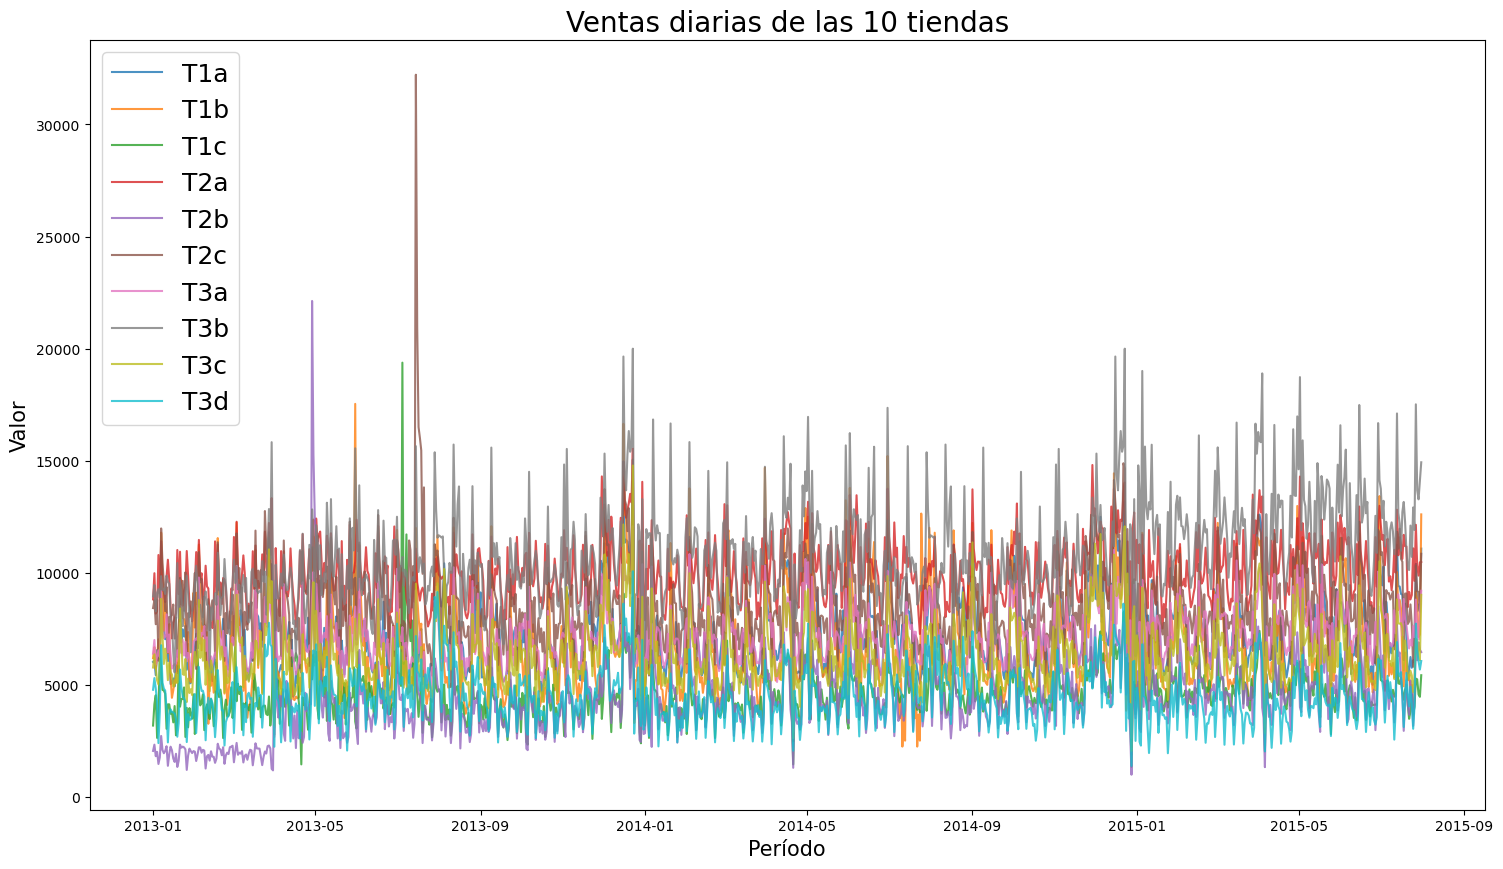

In [85]:
#Ventas diarias de las 10 tiendas
fig, ax = plt.subplots(figsize=(18, 10))

for tienda in sales_df_mod['Store'].unique():
    filtered_df = sales_df_mod.loc[lambda df: df['Store'] == tienda]
    x = filtered_df.index
    y = filtered_df['Sales']
    ax.plot(x, y, label=tienda, alpha= 0.8)
    
ax.legend(fontsize=18)
ax.set_ylabel('Valor', fontsize= 15)
ax.set_xlabel('Período', fontsize= 15)
ax.set_title('Ventas diarias de las 10 tiendas', fontsize= 20)

plt.show()

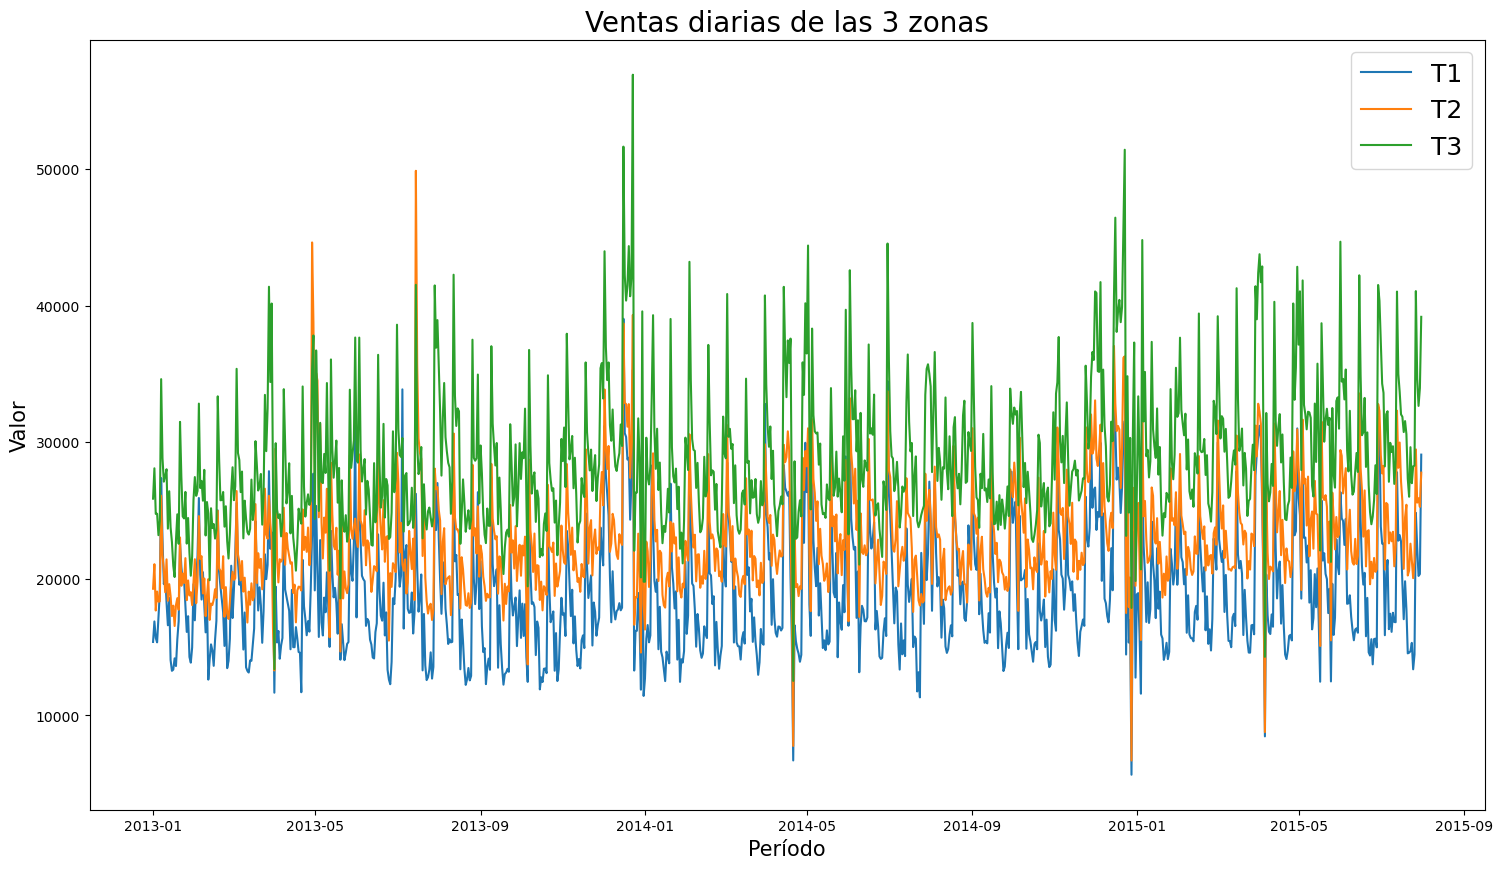

In [84]:
agg_zonas = sales_df_mod.groupby([sales_df_mod['Store'].str[:2], 'Date']).sum().reset_index()

agg_zonas = agg_zonas.set_index('Date')

fig, ax = plt.subplots(figsize=(18, 10))

for zona in agg_zonas['Store'].unique():
    filtered_df = agg_zonas.loc[lambda df: df['Store'] == zona]
    x = filtered_df.index
    y = filtered_df['Sales']
    ax.plot(x, y, label=zona, alpha= 1)
    
ax.legend(fontsize=18)
ax.set_ylabel('Valor', fontsize= 15)
ax.set_xlabel('Período', fontsize= 15)
ax.set_title('Ventas diarias de las 3 zonas', fontsize= 20)

plt.show()

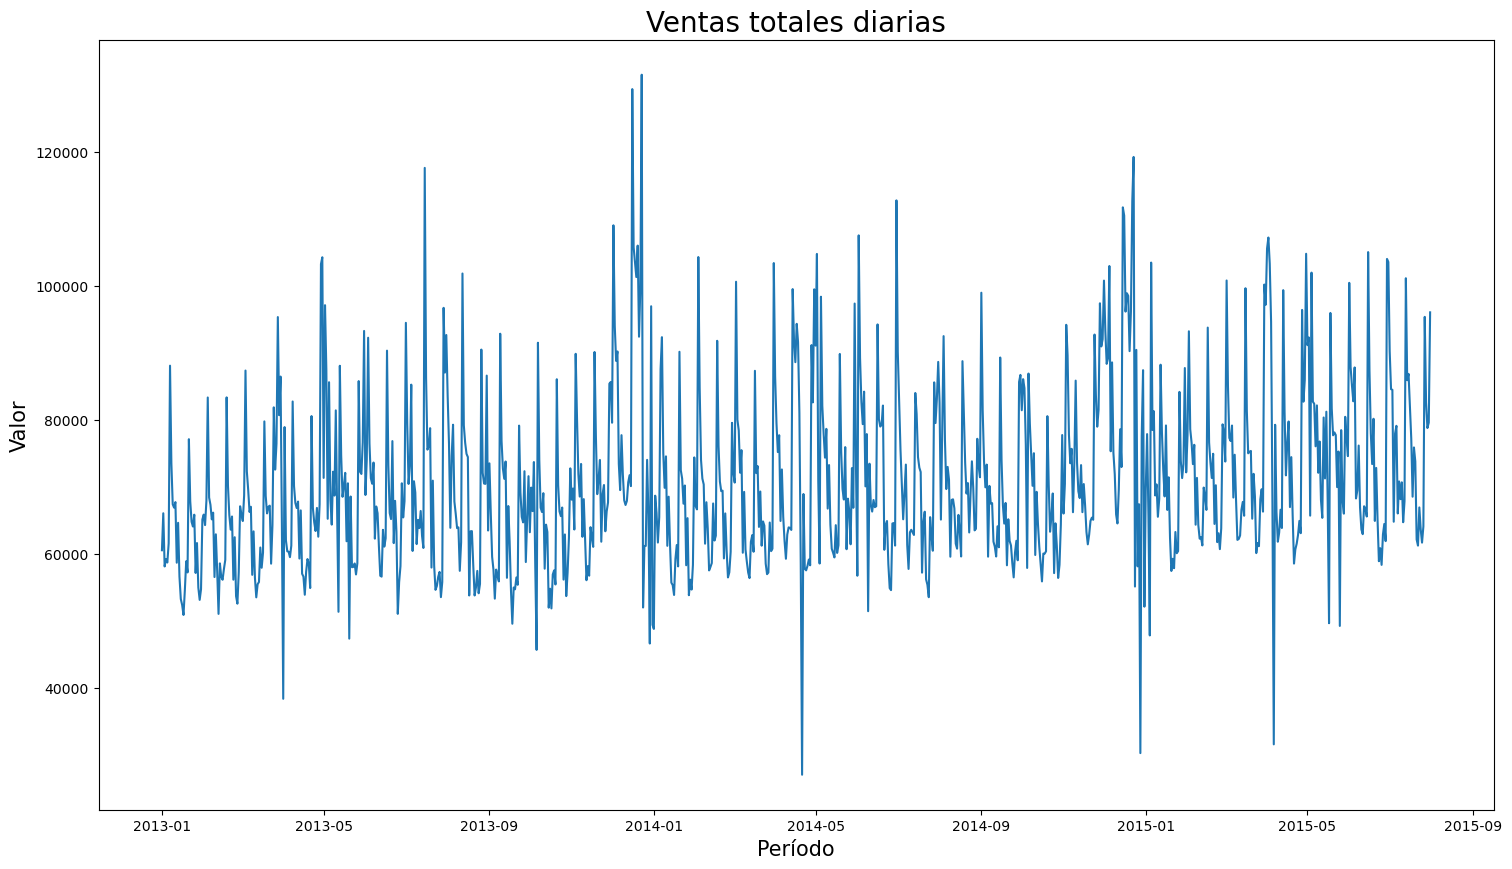

In [86]:
agg_sales_d = sales_df_mod.groupby('Date')['Sales'].sum().to_frame()

fig, ax = plt.subplots(figsize=(18, 10))

x = agg_sales_d.index
y = agg_sales_d['Sales']
ax.plot(x, y, alpha= 1)
ax.set_ylabel('Valor', fontsize= 15)
ax.set_xlabel('Período', fontsize= 15)
ax.set_title('Ventas totales diarias', fontsize= 20)

plt.show()

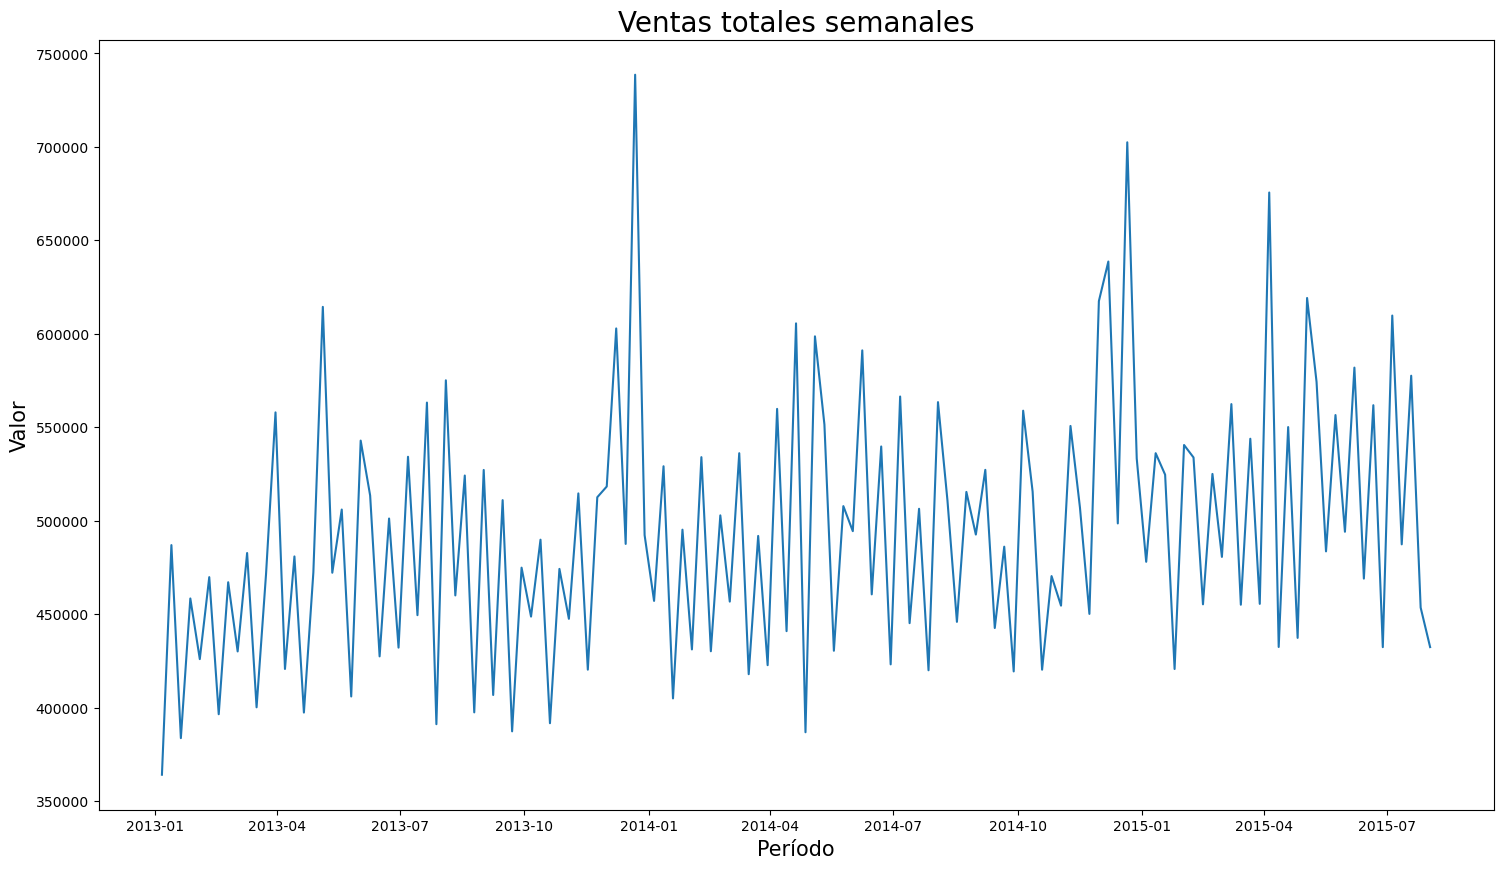

In [92]:
agg_sales_w = sales_df_mod.resample('W').sum()

fig, ax = plt.subplots(figsize=(18, 10))

x = agg_sales_w.index
y = agg_sales_w['Sales']
ax.plot(x, y, alpha= 1)
ax.set_ylabel('Valor', fontsize= 15)
ax.set_xlabel('Período', fontsize= 15)
ax.set_title('Ventas totales semanales', fontsize= 20)

plt.show()

In [95]:
#Ventas y consumidores segun día de la semana

#Creo un df agrupando por dias de la semana y calculando la media para ventas y clientes
agg_dw = (df_datos
           .groupby(['DayOfWeek'], as_index=False)
           .agg({'Sales': 'mean',
                'Customers': 'mean'})
           .assign(**{'DayOfWeek': lambda df: df['DayOfWeek'].replace({
        1: 'Lunes', 2: 'Martes', 3: 'Miercoles', 4:'Jueves', 5: 'Viernes', 6: 'Sabado', 7: 'Domingo'})}))

fig_dia = px.bar(agg_dw, x='DayOfWeek', y=['Sales', 'Customers'], title="Ventas y clientes según día de la semana", 
             barmode="group", labels={'DayOfWeek':'Dias de la semana'})

fig_dia.show()

Los lunes son el día que más ventas se realizan y más clientes entran a la tienda, seguido del martes. A partir de aquí comienzan a disminuir, hasta el viernes que vuelven a aumentar. Los jueves y sábados son en los que menos ventas se realizan y menos clientes acuden a las tiendas.

Los domingos las tiendas permanecen cerradas, por lo que las ventas y los clientes son nulos. **La mayoría de datos con valor 0 que tenemos en el fichero y hemos sustituido en el apartado anteriores concuerdan con este día.**

In [96]:
#Ventas y consumidores segun promo

#Creo un df agrupando por la columna promo y calculando la media para ventas y clientes
agg_promo = (df_datos
           .groupby(['Promo'], as_index=False)
           .agg({'Sales': 'mean',
                'Customers': 'mean'})
           .assign(**{'Promo': lambda df: df['Promo'].replace({
        1: 'Promocion', 0: 'No promocion'})}))

fig_promo = px.bar(agg_promo, x='Promo', y=['Sales', 'Customers'], title="Ventas y clientes según promoción", 
             barmode="group")

fig_promo.show()

Los días en los que hay promoción la media de las ventas es bastante superior a los días en los que no la hay, y por consiguiente, el número de clientes también.

In [98]:
#Ventas y consumidores segun días lectivos

#Creo un df agrupando por la columna SchoolHoliday y calculando la media para ventas y clientes
agg_lect = (df_datos
           .groupby(['SchoolHoliday'], as_index=False)
           .agg({'Sales': 'mean',
                'Customers': 'mean'})
           .assign(**{'SchoolHoliday': lambda df: df['SchoolHoliday'].replace({
        1: 'Lectivo', 0: 'No lectivo'})}))

fig_lect = px.bar(agg_lect, x='SchoolHoliday', y=['Sales', 'Customers'], title="Ventas y clientes según días lectivos", 
             barmode="group")

fig_lect.show()

Los clientes prefieren realizar compras los días lectivos. Como se ve en la gráfica, las ventas y el número de clientes son mayores en esos días.

In [150]:
from darts.utils.utils import SeasonalityMode, TrendMode, ModelMode
from darts import TimeSeries
from darts.models import ExponentialSmoothing
from darts.metrics import mape

754 188


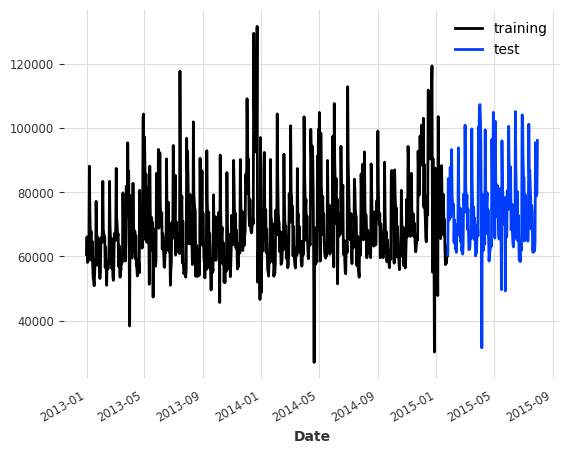

In [148]:
#Lo paso a serie
sales_serie = TimeSeries.from_dataframe(sales_agg)

#Separo los datos en train y test, para que los ultimos 6 meses de la muestran sean test
y_train_ets, y_test_ets = sales_serie.split_before(pd.Timestamp("20150125"))

y_train_ets.plot(label="training")
y_test_ets.plot(label="test")


print(len(y_train_ets), len(y_test_ets))

C:\Users\Alba\anaconda3\envs\series\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


model ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=365 obtains MAPE: 13.13%


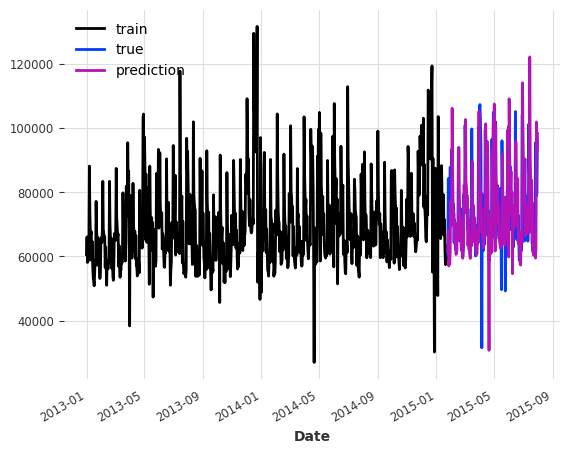

In [178]:
#Modelo
modelo_ets = ExponentialSmoothing(trend=ModelMode.ADDITIVE, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=365)
modelo_ets.fit(y_train_ets)

#Predicciones
pred_ets = modelo_ets.predict(len(y_test_ets))

#Grafico de las predicciones
y_train_ets.plot(label="train")
y_test_ets.plot(label="true")
pred_ets.plot(label="prediction")

print("model {} obtains MAPE: {:.2f}%".format(modelo_ets, mape(y_test_ets, pred_ets)))